In [1]:
import pandas as pd
import os
import base64
import time
import pickle as p
import numpy as np
import matplotlib.pyplot as plt
import pandas.core.algorithms as algos
from sklearn.model_selection import train_test_split
from sklearn import metrics
from functools import reduce
import datetime
from dateutil.relativedelta import relativedelta
import logging
import matplotlib.style as style
import matplotlib
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
import gc
gc.collect()

51

In [4]:
# Client & TPA

TPA = pd.read_excel('../data/Copy_of_TPA_cash.xlsx',sheet_name='Sheet1')
Client = pd.read_excel('../data/Client_info_20191118.xlsx',sheet_name='Sheet1')
# 3 Clients have duplicates records
# Client[Client['Client ID'].isin([1500,7601,2449])]
Client = Client.drop(Client.index[[0,1,497]])


Client = Client.merge(TPA,how='left',left_on='Client ID',right_on='HOST ID')
Client['TPA'] = Client['TPA_x']
Client.loc[Client['TPA_x'].isnull(),'TPA'] = Client.loc[Client['TPA_x'].isnull(),'TPA_y']
Client['TPA'] = Client['TPA'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Client.drop(['TPA_x','TPA_y','HOST ID'],axis=1,inplace = True)

In [5]:
### 1. Customer Dataset

Customer_old = pd.read_csv('../data/Customer_Data_Request_20191121.csv')
Customer = pd.read_csv('../data/Customer_Data_Request_20191217.csv')

# Append these 2 dataframes together
Customer = Customer_old.append(Customer,ignore_index = True)
# 2 Customer has duplicating records, we pick ClientID 2049 as their real Client but this is just a random choice
# Customer[Customer['Unique_Customer_ID']==100541023,100696306]
# Drop the duplicates customerID by index
Customer = Customer.drop(Customer.index[[72898,51730]])


# Some data cleaning here, eliminate the customers with following cases
# Customer_Salary has NaN, 0 and '.'
# Assigned_Spending_Limit has 0
# Customer_Tenure has NaN

# Customer = Customer[(Customer['Assigned_Spending_Limit'] != 0) & 
#                     (~Customer['Customer_Salary'].isin([0, '.'])) & 
#                     (Customer['Customer_Salary'].notnull())&
#                     (Customer['Customer_Tenure'].notnull())]



 # Formating conversion
Customer['Street1'] = Customer['Street1'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Customer['Street2'] = Customer['Street2'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Customer['City'] = Customer['City'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Customer['Status'] = Customer['Status'].apply(lambda x: x.upper() if pd.notnull(x) else np.nan)
Customer.loc[Customer['Customer_Salary']=='.','Customer_Salary']=np.nan
Customer['Customer_Salary'] = Customer['Customer_Salary'].astype(float)
Customer['Enrollment_Date'] = pd.to_datetime(Customer['Enrollment_Date'].astype(str), format='%m/%d/%Y')
Customer.loc[Customer['Term_Date']=='.','Term_Date'] = np.nan
Customer['Term_Date'] = pd.to_datetime(Customer['Term_Date'].astype(str), format='%m/%d/%Y')

Customer = Customer.merge(Client,how='left',left_on='Unique_Company_ID',right_on='Client ID')
Customer.head()

,Unique_Customer_ID,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1,Street2,City,State,Zip,Status,Term_Date,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,Launch Date,Termination Date,Affiliate/Fed Gov?,CLIENT CODE,CLIENT NAME,CLIENT AR,Cash,TPA
0,100001115,1000,2014-02-24,6880.0,230.0,58229.0,Repeat Buyer,1471 N EAST ST,NaN,YORK,PA,17406,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
1,100001120,1000,2014-02-24,6520.0,362.0,109245.0,Repeat Buyer,94 BRENTWOOD LN,NaN,VALLEY STREAM,NY,11581,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
2,100001141,1000,2014-02-25,10290.0,337.0,127226.0,Repeat Buyer,103 KENILWORTH PARK DR,APT 2B,TOWSON,MD,21204,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
3,100001158,1000,2014-02-24,5190.0,419.0,49375.0,Repeat Buyer,1036 BRADDISH AVE,NaN,BALTIMORE,MD,21216,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
4,100001169,1000,2014-02-24,7500.0,448.0,69460.0,Repeat Buyer,3915 W ROGERS AVE,NaN,BALTIMORE,MD,21215,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA


In [6]:
### 2. Performance Dataset

Perf_11 = pd.read_csv('../data/Performance_Data_Request_20191217.csv')
Perf = pd.read_csv('../data/Performance_Data_Request_20191204.csv')
# Deal with the column name mismatching issue before appending the 2 dataframes together
Perf_11.rename(columns = {' Unique_Order_ID':'Unique_Order_ID','Order_date':'Order_Date'},inplace = True)
Perf.rename(columns = {'items_ordered':'Items_Ordered','EMPSTATUS':'Customer_Status'},inplace = True)
Perf = Perf.append(Perf_11, ignore_index=True)

# Make sure the data order is aligned with OrderID & Y-M
Perf['Year_and_Month'] = pd.to_datetime(Perf['Year_and_Month'].astype(str), format = '%Y%m')
Perf = Perf.sort_values(['Unique_Order_ID','Year_and_Month'],ascending = [False,True])

# Create new column - YQ and Year
Perf['YQ'] = pd.PeriodIndex(Perf['Year_and_Month'], freq='Q')
Perf['Year'] = Perf['YQ'].dt.year

Perf.loc[Perf['Date_account_went_delinquent']=='.','Date_account_went_delinquent'] = np.nan
Perf['Date_account_went_delinquent'] = pd.to_datetime(Perf['Date_account_went_delinquent'].astype(str), format='%m/%d/%Y')


# Assign Payment Order as a new column
Perf['Payment_Order'] = Perf.groupby('Unique_Order_ID')['Year_and_Month'].rank(method='first')

# Treat 151+ ad CO as BAD
Perf['Bad']=0
Perf.loc[Perf['Default_Status'].isin(['151+','Chargeoff']),'Bad']=1
# Create a flag Ever_Bad to distinguish first time bad and non-first time bad 
Perf['Ever_Bad'] = Perf.groupby('Unique_Order_ID')['Bad'].transform(pd.Series.cumsum)

# Create 2os Loss, using Losses for C/O orders and Current_Balance for 151+ orders
Perf['2os_loss'] = 0
Perf.loc[Perf['Default_Status']=='Chargeoff','2os_loss'] = Perf.loc[Perf['Default_Status']=='Chargeoff','Losses']
Perf.loc[Perf['Default_Status']=='151+','2os_loss'] = Perf.loc[Perf['Default_Status']=='151+','Current_Balance']


# Perf['Enrollment_Date'] = pd.to_datetime(Perf['Enrollment_Date'].astype(str), format = '%m/%d/%Y')

# Some cleaning here
Perf.loc[Perf['Order_Amount']=='.','Order_Amount']=np.nan
Perf['Order_Amount'] = Perf['Order_Amount'].astype(float)

Perf = Perf[(Perf['Order_Amount'].notnull()) & (Perf['Order_Amount']!=0)]

Perf.loc[Perf['Payments_Due']=='.','Payments_Due']=np.nan
Perf['Payments_Due'] = Perf['Payments_Due'].astype(float)


Perf = Perf.merge(Customer, how='left',on='Unique_Customer_ID')

In [7]:
#Select Performance Data after 2015
df_15 = Perf[Perf['Year']>=2015]

In [10]:
df_15['2os_bal'] = df_15['Current_Balance']
df_15.loc[df_15['Default_Status']=='Chargeoff','2os_bal']= df_15.loc[df_15['Default_Status']=='Chargeoff','Losses']
df_15.loc[(df_15['Default_Status']=='Chargeoff')&(df_15['Losses']==0),'2os_bal']= df_15.loc[df_15['Default_Status']=='Chargeoff','Current_Balance']
df_15.loc[(df_15['Payment_Order']==1),'2os_bal'] = df_15.loc[(df_15['Payment_Order']==1),'Order_Amount']

In [11]:
# Monthly flow-in loss
d1 = df_15[(df_15['Bad']==1)&(df_15['Ever_Bad']<=1)].groupby('Year_and_Month').agg({'2os_loss':'sum'}).reset_index()

In [16]:
# Monthly balance of active accounts
d2 = df_15.groupby('Year_and_Month').agg({'2os_bal':'sum'}).reset_index()

In [17]:
# Merge these two by `Year and Month`
d3 = d1.merge(d2, how='left', on='Year_and_Month')

In [18]:
d3['loss_rate'] = (d3['2os_loss']/d3['2os_bal'])*12
d3['Year']=d3['Year_and_Month'].dt.year
d3

,Year_and_Month,2os_loss,2os_bal,loss_rate,Year
0,2015-01-01,1534316.62,1.979860e+08,0.092995,2015
1,2015-02-01,1318131.52,1.886862e+08,0.083830,2015
2,2015-03-01,1532162.89,1.833027e+08,0.100304,2015
3,2015-04-01,1309643.19,1.779783e+08,0.088301,2015
4,2015-05-01,1365530.15,1.735526e+08,0.094417,2015
5,2015-06-01,1600372.25,1.709657e+08,0.112329,2015
6,2015-07-01,1976183.22,1.694272e+08,0.139967,2015
7,2015-08-01,1994903.70,1.726408e+08,0.138663,2015
8,2015-09-01,2014090.87,1.691568e+08,0.142880,2015
9,2015-10-01,1888123.44,1.668227e+08,0.135818,2015


In [19]:
d3.groupby('Year').agg({'loss_rate':'mean'}).reset_index()

,Year,loss_rate
0,2015,0.112249
1,2016,0.117316
2,2017,0.122254
3,2018,0.130381
4,2019,0.157164


In [20]:
x = df_15[df_15['Year_and_Month']=='2019-07-01']

In [21]:
x.shape

(716967, 62)

In [22]:
x['Default_Status'].value_counts(dropna=False)

Current       575579
001-030        42839
151+           32479
031-060        17054
061-090        12176
091-120        10437
121-150         9808
Chargeoff       7296
Bankruptcy      6541
Fraud           2758
Name: Default_Status, dtype: int64

In [30]:
c1 = df_15[(df_15['Bad']==1)&(df_15['Ever_Bad']<=1)].groupby('Year').agg({'Unique_Customer_ID':'nunique'})

In [29]:
c2 = df_15.groupby('Year').agg({'Unique_Customer_ID':'nunique'})

In [31]:
c3 = c1.merge(c2, how='left',on='Year')

In [33]:
c3['Bad_Rate'] = c3['Unique_Customer_ID_x']/c3['Unique_Customer_ID_y']

In [35]:
c3.rename(columns={'Unique_Customer_ID_x':'num_of_bad_customers','Unique_Customer_ID_y':'num_of_active_customers'},inplace=True)

In [37]:
c3.reset_index()

,Year,num_of_bad_customers,num_of_active_customers,Bad_Rate
0,2015,19128,242663,0.078825
1,2016,22259,275498,0.080796
2,2017,26686,306643,0.087026
3,2018,31779,335395,0.094751
4,2019,33886,327417,0.103495


In [38]:
# x[(x['Default_Status'].isin(['151+','Chargeoff']))&(x['Ever_Bad']==1)][['Unique_Order_ID','Year_and_Month','Order_Amount','Current_Balance','2os_bal','2os_loss','Default_Status','Bad','Ever_Bad','Payment_Order']]

## Let's do pbads

In [39]:
df_17 = Perf[Perf['Year']>=2017]

In [40]:
df_17_w_bad = df_17[df_17['Account Name'].isin(df_17[(df_17['Bad'] == 1) & (df_17['Ever_Bad'] <= 1)]['Account Name'].tolist())]

In [41]:
Client_sub = Client[Client['Account Name'].isin(df_17_w_bad['Account Name'].unique())]

In [42]:
# # Annual flow Loss by Client
# flow_loss = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(
#     values='2os_loss', index='Account Name', columns='Year', aggfunc='sum').reset_index().rename_axis(None,axis=1)
# # .to_csv('../data/Client_annual_loss.csv')
# flow_loss.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [170]:
# Annual Flow Bad Customers by Client
flow_cust = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(
    values='Unique_Customer_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
#.to_csv('../data/Client_bad_cust.csv')
flow_cust.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [171]:
# Annual On Book # of Customers by Client
total_cust_ob = df_17_w_bad.pivot_table(
    values='Unique_Customer_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
# .to_csv('../data/Client_annual_cust.csv')
total_cust_ob.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [81]:
flow_cust.shape

(371, 4)

In [164]:
pbads = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(values='Unique_Customer_ID', index='Account Name',columns='Year', aggfunc='nunique').reset_index().rename_axis(None, axis=1)
pbads.loc['Total',1:]= pbads.iloc[:,1:].sum(axis=0)
pbads.iloc[:,1:] = pbads.iloc[:,1:].fillna(0).div(pbads.iloc[-1,1:], axis=1)
pbads.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)
pbads = pbads.iloc[:-1,:]

pbads['Avg_pbads'] = pbads.iloc[:,1:].mean(axis=1)
pbads['cum_pbads'] = pbads.sort_values('Avg_pbads',ascending = False)['Avg_pbads'].cumsum()
pbads = pbads.merge(Client_sub[['Account Name','Client ID','Active','Termination Date','Industry']],how='left',on='Account Name')

In [75]:
pbads.shape

(371, 9)

In [165]:
pbads[pbads['Active']=='Y'].sort_values('Avg_pbads',ascending=False)

,Account Name,2017,2018,2019,Avg_pbads,cum_pbads,Client ID,Active,Termination Date,Industry
126,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,0.119717,0.119283,0.120148,0.119716,0.119716,2049,Y,NaT,Federal Government/Associations
331,THE HOME DEPOT,0.087109,0.075542,0.074044,0.078898,0.198614,2302,Y,NaT,Retail Trade
345,TYSON FOODS,0.035801,0.036646,0.035437,0.035962,0.282388,2149,Y,NaT,Manufacturing
95,DAVITA INC,0.030100,0.031167,0.032978,0.031415,0.313803,2250,Y,NaT,Health Care and Social Assistance
81,COMMUNITY HEALTH SYSTEMS,0.028694,0.027239,0.027289,0.027741,0.341544,2422,Y,NaT,Health Care and Social Assistance
85,COMPASS GROUP (NEW),0.000038,0.029393,0.045956,0.025129,0.366673,2496,Y,NaT,Accommodation and Food Services
290,SEANC,0.018205,0.019986,0.014726,0.017639,0.384312,2191,Y,NaT,State Government/Associations
192,KOHL'S DEPARTMENT STORES,0.018433,0.017262,0.016504,0.017399,0.401711,2225,Y,NaT,Retail Trade
3,"ADVANCE AUTO PARTS, INC.",0.016874,0.018592,0.015615,0.017027,0.418739,2218,Y,NaT,Retail Trade
361,WALGREENS FULL-TIME,0.012998,0.023819,0.013244,0.016687,0.435425,2400,Y,NaT,Retail Trade


In [162]:
Client.head()

,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,Launch Date,Termination Date,Affiliate/Fed Gov?,CLIENT CODE,CLIENT NAME,CLIENT AR,Cash,TPA
0,Y,4270,ATLANTIC GENERAL HOSPITAL,418.0,418.0,Health Care and Social Assistance,622110.0,General Medical and Surgical Hospitals,Maryland Hospital Association/PRIME,2006-03-01,NaT,Affiliate,NaN,NaN,NaN,NaN,NaN
1,Y,1000,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
2,Y,3900,"STEPHENS, INC",1000.0,1000.0,Finance and Insurance,523110.0,Investment Banking and Securities Dealing,PPC,2002-02-01,NaT,Affiliate,NaN,NaN,NaN,NaN,NaN
3,Y,2458,FEDERAL MANAGERS ASSOCIATION,200000.0,200000.0,Federal Government/Associations,813920.0,Professional Organizations,NaN,2016-08-22,NaT,Fed Gov,NaN,NaN,NaN,NaN,NaN
4,Y,5006,INDIANA STATE EMPLOYEES ASSOCIATION - ACH,20000.0,20000.0,State Government/Associations,813910.0,Business Associations,PPC,2013-08-05,NaT,Affiliate,NaN,NaN,NaN,NaN,NaN


In [172]:
# Annual pbads Rate by Client
pbads_rate = flow_cust.iloc[:,1:].fillna(0)/total_cust_ob.iloc[:,1:].fillna(0)
pbads_rate['Account Name'] = flow_cust['Account Name']
pbads_rate['Avg_pbads_rate'] = pbads_rate.iloc[:,:-1].mean(axis=1)
pbads_rate = pbads_rate.merge(Client_sub[['Account Name','Client ID','Active','Termination Date','Industry']],how='left',on='Account Name')
pbads_rate[pbads_rate['Active']=='Y'].sort_values('Avg_pbads_rate',ascending = False)

,2017,2018,2019,Account Name,Avg_pbads_rate,Client ID,Active,Termination Date,Industry
45,0.000000,1.000000,NaN,BOEING (RETIREES),0.500000,5001,Y,NaT,Manufacturing
25,0.333333,0.166667,0.750000,"AUGEO AFFINITY MARKETING, INC",0.416667,4022,Y,NaT,"Professional, Scientific, and Technical Services"
125,0.000000,0.000000,1.000000,FEDERAL FIRST,0.333333,2854,Y,NaT,Federal Government/Associations
221,0.400000,0.500000,0.000000,MERCER MARKETPLACE,0.300000,2406,Y,NaT,"Professional, Scientific, and Technical Services"
293,0.210117,0.360544,0.204620,SERCO,0.258427,2351,Y,NaT,"Professional, Scientific, and Technical Services"
123,0.230769,0.363636,0.166667,FAZOLI'S SYSTEM MGMT,0.253691,2254,Y,NaT,Accommodation and Food Services
226,0.254902,0.200000,0.263158,MMC INC,0.239353,2278,Y,NaT,Administrative and Support
10,0.262195,0.219718,0.232353,"ALPHASTAFF, INC.",0.238089,2221,Y,NaT,"Professional, Scientific, and Technical Services"
272,0.194260,0.287979,0.213668,REGIS CORPORATION,0.231969,2402,Y,NaT,Other Services (except Public Administration)
302,0.108108,0.230769,0.279070,SPIRE HOSPITALITY,0.205982,2461,Y,NaT,Administrative and Support


In [173]:
pbads_rate.to_csv('../data/pbads_rate_ind.csv',index = False)

### NoPay Pbads Rate

In [102]:
Initial_bal = Perf.groupby('Unique_Order_ID').head(1)
Initial_bal.loc[Initial_bal['Current_Balance']==0,'Current_Balance'] = Initial_bal.loc[Initial_bal['Current_Balance']==0,'Order_Amount']
CO_bal = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)]
CO_bal.loc[CO_bal['Current_Balance']==0,'Current_Balance'] = CO_bal.loc[CO_bal['Current_Balance']==0,'2os_loss']
CO_new = CO_bal.merge(Initial_bal[['Unique_Order_ID','Current_Balance']], how = 'left', on='Unique_Order_ID')

CO_new['NoPay_Flag'] = CO_new.apply(lambda x: 1 if x['Current_Balance_x']==x['Current_Balance_y'] else 0, axis=1)
CO_new['NoPay_Flag'].value_counts()

0    221808
1     19412
Name: NoPay_Flag, dtype: int64

In [106]:
# Annual Flow pbads by Client
NoPay_pbads = CO_new[CO_new['NoPay_Flag']==1].pivot_table(
    values='Unique_Customer_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
# .to_csv('../data/Client_annual_pbads.csv')
NoPay_pbads.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

In [108]:
NoPay_pbads.shape

(339, 4)

In [111]:
total_cust_ob_sub = total_cust_ob[total_cust_ob['Account Name'].isin(NoPay_pbads['Account Name'].tolist())]

In [114]:
# Annual Loss Rate by Client
NoPay_rate = NoPay_pbads.sort_values('Account Name').iloc[:,1:].fillna(0)/total_cust_ob_sub.reset_index(drop=True).sort_values('Account Name').iloc[:,1:].fillna(0)
NoPay_rate['Account Name'] = NoPay_pbads.sort_values('Account Name')['Account Name']

In [115]:
NoPay_rate['Avg_NoPay_rate'] = NoPay_rate.iloc[:,:-1].mean(axis=1)
NoPay_rate = NoPay_rate.merge(Client_sub[['Account Name','Client ID','Active','Termination Date','Industry']],how='left',on='Account Name')

In [117]:
NoPay_rate[NoPay_rate['Active']=='Y'].sort_values('Avg_NoPay_rate',ascending = False)#['Client ID'].tolist()[:10]

,2017,2018,2019,Account Name,Avg_NoPay_rate,Client ID,Active,Termination Date
23,0.333333,0.000000,0.250000,"AUGEO AFFINITY MARKETING, INC",0.194444,4022,Y,NaT
304,NaN,NaN,0.105263,THE MECHANICS BANK,0.105263,2555,Y,NaT
265,0.103113,0.058957,0.056106,SERCO,0.072725,2351,Y,NaT
201,0.200000,0.000000,0.000000,MERCER MARKETPLACE,0.066667,2406,Y,NaT
100,0.140845,0.000000,0.053763,DYCORA,0.064870,2487,Y,NaT
246,0.097130,0.037649,0.051846,REGIS CORPORATION,0.062208,2402,Y,NaT
9,0.121951,0.025352,0.035294,"ALPHASTAFF, INC.",0.060866,2221,Y,NaT
57,0.031250,0.121951,0.027027,CAPSTONE RESTAURANT GROUP,0.060076,2466,Y,NaT
25,0.094340,0.020408,0.051282,AUTOPART INTERNATIONAL,0.055343,2364,Y,NaT
295,0.082063,0.030097,0.036630,TAKECARE,0.049597,2393,Y,NaT


In [98]:
# CO_bal[CO_bal['Current_Balance']==0][['Unique_Order_ID','Unique_Customer_ID','Order_Amount','Current_Balance','Losses','2os_loss']]

In [99]:
# CO_bal[CO_bal['2os_loss']==0][['Unique_Order_ID','Unique_Customer_ID','Order_Amount','Current_Balance','Losses','2os_loss','Bad','Ever_Bad','Payment_Order','Default_Status']]

In [89]:
CO_bal.shape

(241220, 61)

In [118]:
# CO_new[['Current_Balance_x','Current_Balance_y','NoPay_Flag']]

In [128]:
pbads.head()

,Account Name,pbads_contrib_2017,pbads_contrib_2018,pbads_contrib_2019,Avg_pbads,cum_pbads,Client ID,Active,Termination Date
0,"7-ELEVEN, INC.",0.000456,0.000190,0.000178,0.000275,0.986889,5002,Y,NaT
1,ABINGTON HEALTH,0.000532,0.000443,0.000000,0.000325,0.982181,2362,Consolidated,2018-09-28
2,ACTIVE MILITARY,0.000000,0.000000,0.000030,0.000010,0.999990,1302,Terminated,2015-06-15
3,"ADVANCE AUTO PARTS, INC.",0.016874,0.018592,0.015615,0.017027,0.418739,2218,Y,NaT
4,AECOM,0.002090,0.002597,0.002696,0.002461,0.839442,2439,Y,NaT


In [129]:
pbads_rate.head()

,pbads_rate_2017,pbads_rate_2018,pbads_rate_2019,Account Name,Avg_pbads_rate,Client ID,Active,Termination Date
0,0.210526,0.136364,0.166667,"7-ELEVEN, INC.",0.171186,5002,Y,NaT
1,0.325581,0.538462,0.000000,ABINGTON HEALTH,0.288014,2362,Consolidated,2018-09-28
2,0.000000,0.000000,0.500000,ACTIVE MILITARY,0.166667,1302,Terminated,2015-06-15
3,0.120587,0.151133,0.143989,"ADVANCE AUTO PARTS, INC.",0.138570,2218,Y,NaT
4,0.086751,0.119186,0.126565,AECOM,0.110834,2439,Y,NaT


In [130]:
NoPay_rate.head()

,NoPay_rate_2017,NoPay_rate_2018,NoPay_rate_2019,Account Name,Avg_NoPay_rate,Client ID,Active,Termination Date
0,0.087719,0.000000,0.000000,"7-ELEVEN, INC.",0.029240,5002,Y,NaT
1,0.116279,0.115385,0.000000,ABINGTON HEALTH,0.077221,2362,Consolidated,2018-09-28
2,0.057849,0.020340,0.023497,"ADVANCE AUTO PARTS, INC.",0.033895,2218,Y,NaT
3,0.047319,0.024709,0.013908,AECOM,0.028645,2439,Y,NaT
4,0.100962,0.009217,0.014085,AFNI,0.041421,4028,Y,NaT


In [131]:
total_cust_ob.head()

,Account Name,num_of_active_customers_2017,num_of_active_customers_2018,num_of_active_customers_2019
0,"7-ELEVEN, INC.",57.0,44.0,36.0
1,ABINGTON HEALTH,43.0,26.0,3.0
2,ACTIVE MILITARY,3.0,3.0,2.0
3,"ADVANCE AUTO PARTS, INC.",3682.0,3884.0,3660.0
4,AECOM,634.0,688.0,719.0


In [124]:
prefix = 'pbads_contrib_'
new_names = [(i,prefix + i) for i in ['2017','2018','2019']]
pbads.rename(columns = dict(new_names), inplace=True)

In [125]:
prefix = 'pbads_rate_'
new_names = [(i,prefix + i) for i in ['2017','2018','2019']]
pbads_rate.rename(columns = dict(new_names), inplace=True)

In [126]:
prefix = 'NoPay_rate_'
new_names = [(i,prefix + i) for i in ['2017','2018','2019']]
NoPay_rate.rename(columns = dict(new_names), inplace=True)

In [127]:
prefix = 'num_of_active_customers_'
new_names = [(i,prefix + i) for i in ['2017','2018','2019']]
total_cust_ob.rename(columns = dict(new_names), inplace=True)

In [139]:
[i for i in NoPay_rate['Account Name'].tolist() if i not in pbads['Account Name'].tolist()]

[]

In [133]:
pbads_rate.shape

(371, 8)

In [134]:
NoPay_rate.shape

(339, 8)

In [135]:
total_cust_ob.shape

(371, 4)

In [144]:
data_frames = [pbads, pbads_rate, NoPay_rate]

In [145]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Account Name','Client ID','Active','Termination Date'],
                                            how='outer'), data_frames)


In [147]:
df_merged = df_merged.merge(total_cust_ob, how='left',on='Account Name')
df_merged

,Account Name,pbads_contrib_2017,pbads_contrib_2018,pbads_contrib_2019,Avg_pbads,cum_pbads,Client ID,Active,Termination Date,pbads_rate_2017,pbads_rate_2018,pbads_rate_2019,Avg_pbads_rate,NoPay_rate_2017,NoPay_rate_2018,NoPay_rate_2019,Avg_NoPay_rate,num_of_active_customers_2017,num_of_active_customers_2018,num_of_active_customers_2019
0,"7-ELEVEN, INC.",0.000456,0.000190,0.000178,0.000275,0.986889,5002,Y,NaT,0.210526,0.136364,0.166667,0.171186,0.087719,0.000000,0.000000,0.029240,57.0,44.0,36.0
1,ABINGTON HEALTH,0.000532,0.000443,0.000000,0.000325,0.982181,2362,Consolidated,2018-09-28,0.325581,0.538462,0.000000,0.288014,0.116279,0.115385,0.000000,0.077221,43.0,26.0,3.0
2,ACTIVE MILITARY,0.000000,0.000000,0.000030,0.000010,0.999990,1302,Terminated,2015-06-15,0.000000,0.000000,0.500000,0.166667,NaN,NaN,NaN,NaN,3.0,3.0,2.0
3,"ADVANCE AUTO PARTS, INC.",0.016874,0.018592,0.015615,0.017027,0.418739,2218,Y,NaT,0.120587,0.151133,0.143989,0.138570,0.057849,0.020340,0.023497,0.033895,3682.0,3884.0,3660.0
4,AECOM,0.002090,0.002597,0.002696,0.002461,0.839442,2439,Y,NaT,0.086751,0.119186,0.126565,0.110834,0.047319,0.024709,0.013908,0.028645,634.0,688.0,719.0
5,AFNI,0.001292,0.001014,0.000978,0.001095,0.931652,4028,Y,NaT,0.163462,0.147465,0.154930,0.155286,0.100962,0.009217,0.014085,0.041421,208.0,217.0,213.0
6,ALABAMA STATE EMPLOYEES ASSOCIATION,0.001900,0.001204,0.001215,0.001440,0.906989,2048,Y,NaT,0.066667,0.049608,0.052767,0.056347,0.042667,0.009138,0.011583,0.021129,750.0,766.0,777.0
7,"ALERE, INC.",0.000418,0.000475,0.000148,0.000347,0.981172,2352,Terminated,2017-12-31,0.108911,0.205479,0.250000,0.188130,0.049505,0.041096,0.000000,0.030200,101.0,73.0,20.0
8,ALLIANCE RESIDENTIAL COMPANY,0.000418,0.000222,0.000000,0.000213,0.989734,2259,Terminated,2017-09-17,0.103774,0.152174,0.000000,0.085316,0.047170,0.000000,0.000000,0.015723,106.0,46.0,2.0
9,ALLINA HOSPITALS & CLINICS,0.001786,0.001805,0.002015,0.001869,0.877015,2206,Y,NaT,0.073552,0.083947,0.100443,0.085981,0.032864,0.017673,0.019202,0.023246,639.0,679.0,677.0


In [148]:
df_merged.to_csv('../data/Pbads_view.csv',index = False)

### Pbads Rate vs NoPay pbads Rate

In [149]:
NoPay_pbads

,Account Name,2017,2018,2019
0,"7-ELEVEN, INC.",5.0,NaN,NaN
1,ABINGTON HEALTH,5.0,3.0,NaN
2,"ADVANCE AUTO PARTS, INC.",213.0,79.0,86.0
3,AECOM,30.0,17.0,10.0
4,AFNI,21.0,2.0,3.0
5,ALABAMA STATE EMPLOYEES ASSOCIATION,32.0,7.0,9.0
6,"ALERE, INC.",5.0,3.0,NaN
7,ALLIANCE RESIDENTIAL COMPANY,5.0,NaN,NaN
8,ALLINA HOSPITALS & CLINICS,21.0,12.0,13.0
9,"ALPHASTAFF, INC.",40.0,9.0,12.0


In [ ]:
pbads.loc['Total',1:]= pbads.iloc[:,1:].sum(axis=0)

In [151]:
CO_new[CO_new['NoPay_Flag']==1].groupby('Year').agg({'Unique_Customer_ID':'nunique'}).reset_index()

,Unique_Customer_ID
Year,
2017,12145
2018,4823
2019,6224


In [152]:
df_17_w_bad.groupby('Year').agg({'Unique_Customer_ID':'nunique'}).reset_index()

,Year,Unique_Customer_ID
0,2017,306590
1,2018,335311
2,2019,324781


In [153]:
df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].groupby('Year').agg({'Unique_Customer_ID':'nunique'}).reset_index()

,Year,Unique_Customer_ID
0,2017,26686
1,2018,31779
2,2019,33886


### avg tenure and salary for top4 CO contrib

In [160]:
Client[Client['Client ID'].isin([2049,2302,2149,2250])][['Account Name','Client ID']]

,Account Name,Client ID
6,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,2049
73,TYSON FOODS,2149
184,THE HOME DEPOT,2302
288,DAVITA INC,2250


In [ ]:
[2049,2302,2149,2250]

In [161]:
for client_id in [2049,2302,2149,2250]:
    df = df_17[df_17['Unique_Company_ID']==client_id]
    df.groupby('Year_and_Month').agg({'Customer_Tenure':'mean','Customer_Salary':'mean'}).reset_index().to_csv('../data/{}.csv'.format(client_id),index = False)
#     df_bad = df[(df['Bad']==1) & (df['Ever_Bad']<=1)]
#     df_good = df.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0)
#     df_bad.groupby('Year_and_Month').agg({'Customer_Tenure':'mean','Customer_Salary':'mean'}).reset_index().to_csv('../data/{}_bad.csv'.format(client_id),index = False)
#     df_good.groupby('Year_and_Month').agg({'Customer_Tenure':'mean','Customer_Salary':'mean'}).reset_index().to_csv('../data/{}_good.csv'.format(client_id),index = False)
    
    

In [159]:
df_17.groupby('Year_and_Month').agg({'Customer_Tenure':'mean','Customer_Salary':'mean'}).reset_index().to_csv('../data/df_17.csv',index = False)

In [176]:
Perf.head()

,Unique_Order_ID,Unique_Customer_ID,Order_Amount,Product_Markup,Payments_Due,Current_Balance,Date_account_went_delinquent,Default_Status,Delinquency_Bucket,Losses,Auto_Pay_Enrollment,Order_Closed_Flag,Type_of_Backup_Payment,Spending_Limit_at_time_of_Order,Tenure_at_time_of_Order,Salary_at_time_of_Order,Street1_x,Street2_x,City_x,State_x,Zip_x,Items_Ordered,Year_and_Month,Customer_Status,Order_Date,YQ,Year,Payment_Order,Bad,Ever_Bad,2os_loss,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1_y,Street2_y,City_y,State_y,Zip_y,Status,Term_Date,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,Launch Date,Termination Date,Affiliate/Fed Gov?,CLIENT CODE,CLIENT NAME,CLIENT AR,Cash,TPA
0,YCCZIMM1449606,173585108,349.57,.,6.72,336.00,2014-09-30,Current,000-000,0.0,PD,N,ACH,31.9,146,28308.80,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-01-01,Employed,01/17/2014,2014Q1,2014,1.0,0,0,0.0,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX
1,YCCZIMM1449606,173585108,349.57,.,6.72,309.12,2014-09-30,Current,000-000,0.0,PD,N,ACH,31.9,146,28308.80,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-02-01,Employed,01/17/2014,2014Q1,2014,2.0,0,0,0.0,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX
2,YCCZIMM1449606,173585108,349.57,.,6.72,282.24,2014-09-30,Current,000-000,0.0,PD,N,ACH,31.9,146,28308.80,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-03-01,Employed,01/17/2014,2014Q1,2014,3.0,0,0,0.0,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX
3,YCCZIMM1449606,173585108,349.57,.,6.72,248.64,2014-09-30,Current,000-000,0.0,PD,N,ACH,31.9,146,28308.80,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-04-01,Employed,01/17/2014,2014Q2,2014,4.0,0,0,0.0,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX
4,YCCZIMM1449606,173585108,349.57,.,6.72,221.76,2014-09-30,Current,000-000,0.0,PD,N,ACH,31.9,146,28308.80,397 PARKWAY PLZ,"EL CAJON, CA",EL CAJON,CA,92020.0,The SAK Ventura Convertible Backpack Black; Ji...,2014-05-01,Employed,01/17/2014,2014Q2,2014,5.0,0,0,0.0,2309.0,2014-02-24,3190.0,146.0,28308.8,Repeat Buyer,750 SCRANTON ST,APT 8,EL CAJON,CA,92020,LOA,NaT,Terminated,2309.0,YANKEE CANDLE COMPANY,2104.0,1999.0,Manufacturing,339999.0,All Other Miscellaneous Manufacturing,"Beneplace, Inc",2012-06-15,2014-12-31,Affiliate,NaN,NaN,NaN,NaN,PAYLOGIX


In [175]:
Customer.head()

,Unique_Customer_ID,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1,Street2,City,State,Zip,Status,Term_Date,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,Launch Date,Termination Date,Affiliate/Fed Gov?,CLIENT CODE,CLIENT NAME,CLIENT AR,Cash,TPA
0,100001115,1000,2014-02-24,6880.0,230.0,58229.0,Repeat Buyer,1471 N EAST ST,NaN,YORK,PA,17406,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
1,100001120,1000,2014-02-24,6520.0,362.0,109245.0,Repeat Buyer,94 BRENTWOOD LN,NaN,VALLEY STREAM,NY,11581,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
2,100001141,1000,2014-02-25,10290.0,337.0,127226.0,Repeat Buyer,103 KENILWORTH PARK DR,APT 2B,TOWSON,MD,21204,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
3,100001158,1000,2014-02-24,5190.0,419.0,49375.0,Repeat Buyer,1036 BRADDISH AVE,NaN,BALTIMORE,MD,21216,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA
4,100001169,1000,2014-02-24,7500.0,448.0,69460.0,Repeat Buyer,3915 W ROGERS AVE,NaN,BALTIMORE,MD,21215,EMPLOYED,NaT,Y,1000.0,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,2002-07-01,NaT,Fed Gov,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,TPA sends cash on behalf of client,EAA


In [189]:
df_17.loc[df_17['Tenure_at_time_of_Order']=='.','Tenure_at_time_of_Order'] = np.nan

In [193]:
df_17['Tenure_at_time_of_Order'] = df_17['Tenure_at_time_of_Order'].astype(float)#value_counts(dropna=False)

*===============================================================================================================*
						 FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ENERGY
*===============================================================================================================*


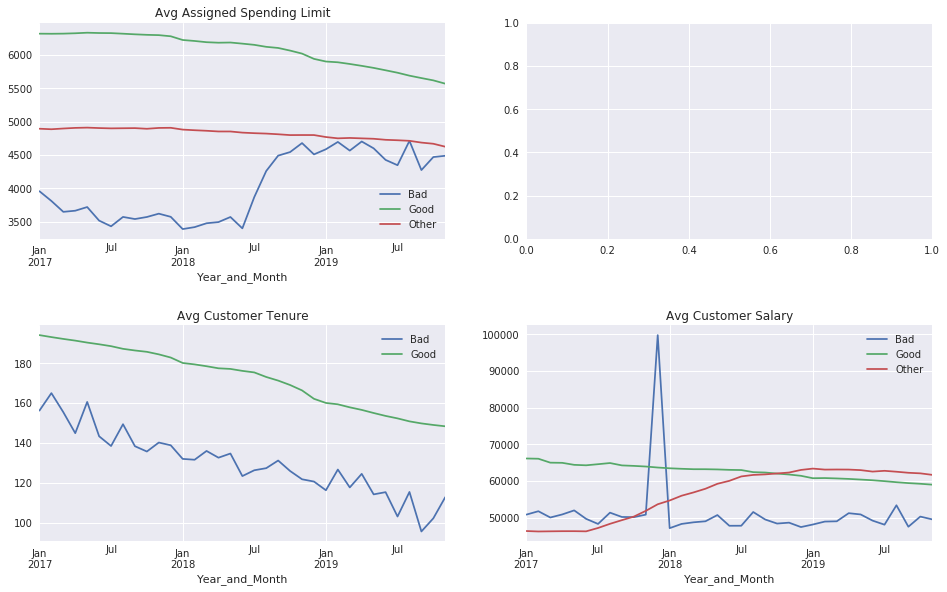

*===============================================================================================================*
						 THE HOME DEPOT
*===============================================================================================================*


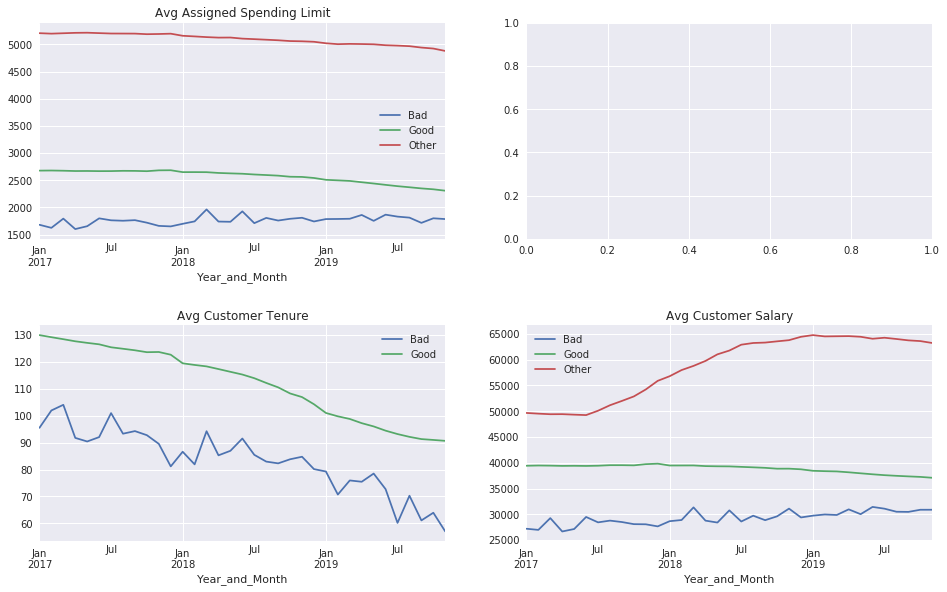

*===============================================================================================================*
						 TYSON FOODS
*===============================================================================================================*


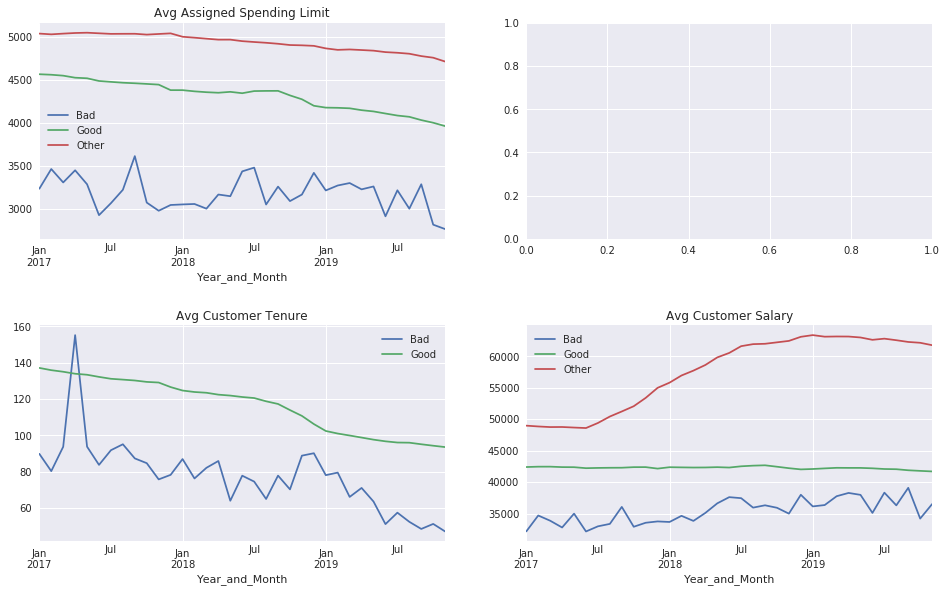

*===============================================================================================================*
						 DAVITA INC
*===============================================================================================================*


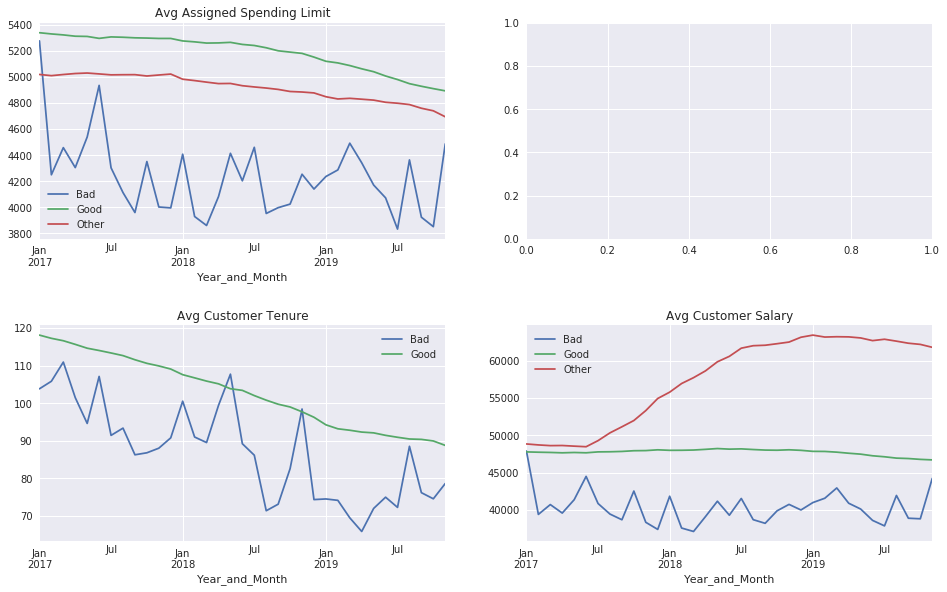

In [194]:
for client_id in [2049,2302,2149,2250]:
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize = (16,9))
    plt.subplots_adjust(left = 0.125,
                        right = 0.9,
                        bottom = 0.1,
                        top = 0.9,
                        wspace = 0.2,
                        hspace = 0.4)
    df = df_17[df_17['Unique_Company_ID']==client_id]
    df_bad = df[(df['Bad']==1) & (df['Ever_Bad']<=1)]
    df_good = df.groupby('Unique_Order_ID').filter(lambda x: x['Ever_Bad'].max()==0)
    rest = df_17[df_17['Unique_Company_ID']!=client_id]
    acct_name = Client[Client['Client ID']==client_id]['Account Name'].values[0]
    print('*===============================================================================================================*')
    print('\t\t\t\t\t\t',acct_name)
    print('*===============================================================================================================*')

    df_bad.groupby('Year_and_Month').agg({'Assigned_Spending_Limit':'mean'}).plot(ax=axes[0,0])
    df_good.groupby('Year_and_Month').agg({'Assigned_Spending_Limit':'mean'}).plot(ax=axes[0,0])
    rest.groupby('Year_and_Month').agg({'Assigned_Spending_Limit':'mean'}).plot(ax = axes[0,0])
    axes[0,0].legend(['Bad','Good','Other'])
    axes[0,0].set_title('Avg Assigned Spending Limit')


    df_bad.groupby('Year_and_Month').agg({'Tenure_at_time_of_Order':'mean'}).plot(ax=axes[1,0])
    df_good.groupby('Year_and_Month').agg({'Tenure_at_time_of_Order':'mean'}).plot(ax=axes[1,0])
    axes[1,0].legend(['Bad','Good'])
    axes[1,0].set_title('Avg Customer Tenure')

    df_bad.groupby('Year_and_Month').agg({'Customer_Salary':'mean'}).plot(ax=axes[1,1])
    df_good.groupby('Year_and_Month').agg({'Customer_Salary':'mean'}).plot(ax=axes[1,1])
    rest.groupby('Year_and_Month').agg({'Customer_Salary':'mean'}).plot(ax=axes[1,1])
    axes[1,1].legend(['Bad','Good','Other'])
    axes[1,1].set_title('Avg Customer Salary')
    plt.show()

In [ ]:
# # Annual Loss Contribution by Client
# loss_contrib = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(values='2os_loss', index='Account Name',columns='Year', aggfunc='sum',margins = True).reset_index().rename_axis(None, axis=1).iloc[:,:-1]
# # loss_contrib.iloc[:,1:] = loss_contrib.iloc[:,1:].div(loss_contrib.All, axis=0)
# loss_contrib.iloc[:,1:] = loss_contrib.iloc[:,1:].div(loss_contrib.iloc[-1,1:], axis=1)
# loss_contrib.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)
# loss_contrib = loss_contrib.iloc[:-1,:]

# loss_contrib['Avg_loss_contrib'] = loss_contrib.iloc[:,1:].mean(axis=1)
# loss_contrib['cum_loss_contrib'] = loss_contrib.sort_values('Avg_loss_contrib',ascending = False)['Avg_loss_contrib'].cumsum()
# loss_contrib = loss_contrib.merge(Client_sub[['Account Name','Client ID','Active','Termination Date']],how='left',on='Account Name')

In [ ]:
# # Annual Flow Bad Orders by Client
# flow_ord = df_17_w_bad[(df_17_w_bad['Bad'] == 1) & (df_17_w_bad['Ever_Bad'] <= 1)].pivot_table(
#     values='Unique_Order_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
# #.to_csv('../data/Client_bad_order.csv')
# flow_ord.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

# # Annual On Book $Order Amount by Client
# total_amt_ob = df_17_w_bad.groupby(['Year', 'Unique_Order_ID']).head(1).pivot_table(
#     values='Order_Amount', index='Account Name', columns='Year', aggfunc='sum').reset_index().rename_axis(None,axis=1)
# # .to_csv('../data/client_annual_ob_vol.csv')
# total_amt_ob.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)

# # Annual On Book # of Orders by Client
# total_ord_ob = df_17_w_bad.pivot_table(
#     values='Unique_Order_ID', index='Account Name', columns='Year', aggfunc='nunique').reset_index().rename_axis(None,axis=1)
# # .to_csv('../data/Client_annual_order.csv')
# total_ord_ob.rename(columns = {2017:'2017',2018:'2018',2019:'2019'},inplace = True)


In [ ]:
def vintage_dollar_view(df, YQ, vintage):
    order_list = vintage[vintage['YQ'] == YQ]['Unique_Order_ID'].unique()
    total_balance = vintage[vintage['YQ'] == YQ]['Current_Balance'].sum()
    df_YQ = df[df['Unique_Order_ID'].isin(order_list)]
    df_DQ = df_YQ[df_YQ.Default_Status.isin(['151+', 'Chargeoff'])]
    df_DQ = df_DQ.loc[df_DQ.groupby('Unique_Order_ID')[
        'Year_and_Month'].idxmin()]
    view = df_DQ.groupby('Year_and_Month').agg({'Current_Balance':'sum'}).reset_index()
    temp = pd.DataFrame({'month_order': np.arange(1, 31), 'Year_and_Month': np.array(
        pd.date_range(start=YQ.to_timestamp(), periods=30, freq='MS'))})
    view = temp.merge(view, how = 'left',on='Year_and_Month')
    view = view.fillna(0)
    
    view['DQ_Balance'] = view['Current_Balance'].cumsum()
    view['DQ_Rate'] = view['DQ_Balance']/total_balance

#     view['month_order'] = np.arange(1+round((view['Year_and_Month'].min()-df_YQ['Year_and_Month'].min())/np.timedelta64(1, 'M')), len(
#         view)+1+round((view['Year_and_Month'].min()-df_YQ['Year_and_Month'].min())/np.timedelta64(1, 'M')))
    view.rename(columns = {'DQ_Rate':str(YQ)+'_Vintage'},inplace = True)
    return view